# Init

## Utils

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn import svm
from sklearn.model_selection import cross_validate

# Data

## Load Data

In [22]:
def get_summary(table, field):
    print("nan ratio:", table[field].isnull().sum()/table.shape[0])
    print("nan rows: ", table[field].isnull().sum())
    print(table[field].fillna("nan").value_counts())
    
def email_cleanup(table, key="emailaddress1"):
    if key not in table.columns:
        raise "key is not in table.columns"
    table = table.dropna(subset=[key]) # remove nan
    table.loc[:, key] = table[key].str.replace("'", "").str.lower() # lower case, clean single quote
    table = table[(~table[key].str.contains("rockwell|pisrc|bounteous|test"))] # remove rockwell related email
    return table

### AEM.raw (bingeID Only)
- stage 1 should not drop duplicate because the eventlist probably exist only on some of pdf view records

In [27]:
# _dt = pd.read_csv("all_binge_data_TOP1000000_2022-10-16.csv", nrows=1000000, index_col=0)
aem_raw = pd.read_csv("aemRaw_2022-04-21-all_fields.csv", index_col=0)
stage1_raw = aem_raw.dropna(subset=["BingeScoredAssetPath"]).reset_index(drop=True)
# stage1_raw = stage1_raw.drop_duplicates(subset=["DateTime_UTC", "EloquaContactId", "SessionVisitorId", "BingeScoredAssetPath"], keep='last') 

stage2_raw = aem_raw.dropna(subset=["BingeScoredAssetPath"]).reset_index(drop=True)
# stage2_raw = stage2_raw.drop_duplicates(subset=["DateTime_UTC", "SessionVisitorId", "BingeScoredAssetPath"], keep='last')

print("stage1_raw: unique SessionVisitorId: ", stage1_raw["SessionVisitorId"].unique().shape)
print("stage2_raw: unique SessionVisitorId: ", stage2_raw["SessionVisitorId"].unique().shape)

stage1_raw: unique SessionVisitorId:  (1517,)
stage2_raw: unique SessionVisitorId:  (1517,)


### crm Lead
- unique EloquaContactId -> do some update on this table for the same ID

In [4]:
_lead = pd.read_csv("crm_Lead_20221116_all.csv", index_col=0)
crm_lead = email_cleanup(_lead, "emailaddress1")

/Users/wy/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,9,13,15,17,31,43,44,45,46,49,50,51,56,58,59,63,64,68,70,72,74,76,78,81,83,84,85,89,92,94,97,99,109,112,113,114,115,117,124,135,136,137,138,140,142,143,144,145,157,159,164,165,166,167,178,182,185,188,198,200,204,207,208,216,217,219,223,224,229,230,232,238,240,246,247,252,253,256,257,258,261,262,266,267,268,272,274,275,284,286,287,289,293,294,307,311,313) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/wy/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilo

### elo.contact
- from gated content form?
- unique EloquaContactId -> do some update on this table for the same ID

In [5]:
# _elq = pd.read_csv("all_elo_data_TOP1000000_2022-10-16.csv", nrows=1000000, index_col=0)
_elq = pd.read_csv("elq_all_bridge-only.csv", index_col=0)
elq = email_cleanup(_elq, "EmailAddress")
elq_bridge = elq[["EmailAddress", "EloquaContactId"]]


/Users/wy/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
elq_bridge.groupby("EmailAddress").size().sort_values()

EmailAddress
!!edson.carlos!!@ensinger.co.uk          1
marina.schmidt@szmh-group.com            1
marina.schirmel@scherdel.de              1
marina.schiffer@scheidt-bachmann.com     1
marina.schetino@macrotec.ind.br          1
                                        ..
c_rudiyono@yahoo.com                    15
dixie_bvn@hotmail.com                   17
123@yahoo.com                           18
eric.dacer@ptcerna.com                  20
nancy.cordoba@elvatron.com              21
Length: 6257411, dtype: int64

# Ideas
- business targets
    1. attractness: provide more interesting content for users
        - ranking content + recommendation based
    2. engagement: reach out and prioritize on target users
        - identify potential lead, find patterns and build segmentations between users based on their upload informaton
            - website visiting records -> AEM.raw? <font color=red>need specialized and ingested related data...</font>
            - interactions with sales people -> CRM.Lead? <font color=red>need clean, maintain and more explaination on the existing data... </font>
            - their demographic information -> CRM.Lead / Elq.Contact (this is quite clean)
    3. conversion: sales people effort?
    4. retain: ...

- questions
    - `Next steps: use data that is going into content scoring to predict user propensity`
    - how this weight score can help next step for potential lead prediction?
        - treat it as an feature to another model? the distance between sample is more important. It should be separatable.
        - two-stage model? or just change labels
        
- reference:
    - e.g. in recommendation system
    - <img src="https://assets.zilliz.com/2_29e27eb9b1.png" width="400"/>
    - <img src="https://cdn-images-1.medium.com/max/800/0*U5iR5NTSChuSOcyc." width="400"/>

### funnel

<div>
    <img src="https://www.wordstream.com/wp-content/uploads/2022/08/content-marketing-funnel-full-size.png" width="500"/>
</div>
    

# Feature Engineering

- TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)
    - idf(t) = log(N/(df + 1))
        <img src="https://cdn-media-1.freecodecamp.org/images/1*q3qYevXqQOjJf6Pwdlx8Mw.png" width="500"/>
        <img src="https://preview.redd.it/clwuxvtqpeq91.png?width=397&format=png&auto=webp&s=ae6788cefae9b83b3033db3612ec83e8f5ded24f" width="500"/>
    - rather directly using count frequency in the naive bayesian, using TF-IDF to adjust the features
    
- preprocessing.StandardScaler()
    - should not use because the features importance are dependent on the frequency, which is already kind of information

## stage1: wrapping data
- label: Submitted gated form (target)
    - generated by EventList
- features:
    - choosed:
        - BingeScoredAssetPath: Current BingeScoredAssetPath interaction on one session ( content sequence )
        - DateTime_UTC -> for concat sequence in visited order
    - possible:
        - BingeScoredAssetScore = manually set -> importance level for sales people
        - BingeCriticalScore = manually threshold -> initial threshold for sales people
        - PageURL? what information this URL can bring into model?
        
- original asset score manual setup ideas:
    - asset weight average is 1, if it is more important/meaningful -> bump up to 2;
    - if there are 5 assets in total, then default basic threshold is 5

## stage2: wrapping data
- label: is qualified lead or not (target)
    - stored on CRM Lead table, marked by sales people
- features: all the activities during the journey -> including asset browsing history 
    - choosed:
        - BingeScoredAssetPath: Current BingeScoredAssetPath interaction on one session ( content sequence )
        - DateTime_UTC -> for concat sequence in visited order
    - possible:
        - User information <font color=red>(this part are useful)</font>
            - industry
            - company size 
            - ...

In [12]:
def preprocessing_stage(session, stage=1, target_method=0, feature_method="sequential", sep="$"):
    if stage == 1:
        if target_method == 0:
            target_event = [125, 126]
            events = ",".join(session["EventList"].drop_duplicates().tolist())
            y = any([True for e in target_event if "," + str(e) in events]) * 1
        elif target_method == 1:
            y = (~session["EloquaContactId"].isnull()).any()
        else:
            raise "no such target_method"
            
    elif stage == 2:
        y = any(session["label"]) * 1
    
    if feature_method == "bow":
        page_view = session.groupby("BingeScoredAssetPath")["BingeScoredAssetPath"].size().to_dict() # dict vectorizer
    elif feature_method == "sequential":
        page_view = sep.join(session.sort_values(by="DateTime_UTC")["BingeScoredAssetPath"].tolist())
    else:
        raise "no such feature_method"
    
    # init_scores = session.groupby(["BingeScoredAssetPath"])[["BingeCriticalScore","BingeScoredAssetScore"]].mean() # not sure how to append as weighted matrix
#     asset_session_seq = session.sort_values(by="DateTime_UTC")["BingeScoredAssetPath"].tolist()
    return pd.Series([page_view, y], index=["features", "label"])

def evaluate_metrics(y_test, y_pred, show_plots=False):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    auc_score = auc(fpr, tpr)
    pre, rec, thresholds = precision_recall_curve(y_test, y_pred, pos_label=1)
    prc_score = auc(rec, pre)

    if show_plots:
        print(classification_report(y_test, y_pred>0.5))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('AUC')

        plt.subplot(1, 2, 2)
        plt.plot(rec, pre, color='darkorange', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('PRC')
        plt.tight_layout()

        plt.show()

    print("AUC: {:.2%}, PRC: {:.2%}".format(auc_score, prc_score))
    
SEP_TOKEN_PATTERN = "[^\$]+"
SEED = 42
TEST_SIZE = 0.2

# Modeling



## Stage-1: Scoring content - visitor preference 
- rethink:
    - what is the most attractive content for visitor v.s. what is the most attractive content for salespeople?
        - SubmitGatedForm action is not marked by sales people, it's kind of inclination level from user side
        - the model is trying to know which asset is more important for SubmitGatedForm 
        - how important for user to submit GCDC

    - weight should be from sales people definition, but current method can only get the attractive score on visitor aspect => 
        - assumption-1: more clicks => interesting to connect? <font color=red>submit GCDC == made a reach out decision? YES?</font>
        - they will think the information are valuable for them, want to get more related information -> salespeople reach out? When is the time = threshold?

In [8]:
data = stage1_raw.groupby("SessionVisitorId").apply(lambda x: preprocessing_stage(x))

### Data split + TFIDF
<!-- 
# ## outdated
# data = stage1_raw.groupby("SessionVisitorId").apply(lambda x: processing_stage1(x, target_method=1, feature_method="bow"))
# data["submitted_form"].value_counts()

# def tfidf_transform(dtm, idf=None):
#     N = dtm.shape[0] # number of document
#     tf = (dtm/(dtm.sum(axis=1).reshape(-1,1)))

#     if idf is None:
#         idf = np.log(1 + N/(dtm.astype(bool).sum(axis=0)))
        
#     tfidf = tf * idf
#     return tfidf, idf
# v = DictVectorizer(sparse=False)
# X_train_dtm = v.fit_transform(X_train)
# X_test_dtm = v.transform(X_test)
# X_train_arr, idf = tfidf_transform(X_train_dtm)
# X_test_arr, _ = tfidf_transform(X_test_dtm, idf) -->

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data["features"], data["label"].values, test_size=TEST_SIZE, stratify=data["label"].values, random_state=SEED)

print("training sample label size:", Counter(y_train))
print("pos vs neg in training set:")
print(data["label"].value_counts())
print("testing sample label size:", Counter(y_test))

vectorizer = TfidfVectorizer(token_pattern=SEP_TOKEN_PATTERN)

X_train_arr = vectorizer.fit_transform(X_train)
X_test_arr = vectorizer.transform(X_test)

training sample label size: Counter({0: 1155, 1: 58})
pos vs neg in training set:
0    1444
1      73
Name: label, dtype: int64
testing sample label size: Counter({0: 289, 1: 15})


### Models

#### LR

In [10]:
model = LogisticRegression()
model.fit(X_train_arr, y_train)
# model.coef_

LogisticRegression()

#### svm (x)
- no weight but only predict prob 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       289
           1       0.00      0.00      0.00        15

    accuracy                           0.95       304
   macro avg       0.48      0.50      0.49       304
weighted avg       0.90      0.95      0.93       304



/Users/wy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


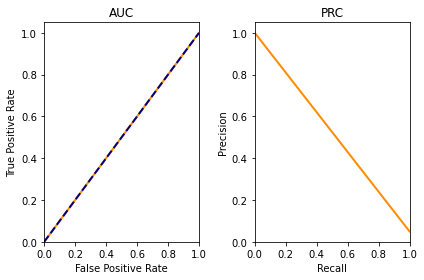

AUC: 50.00%, PRC: 52.47%


In [13]:
svm_clf = svm.SVC(kernel='linear', C=1)
svm_clf.fit(X_train_arr, y_train)
y_pred = svm_clf.predict(X_test_arr)
evaluate_metrics(y_test, y_pred, show_plots = True)

#### naive bayes
- $\theta_{yi}$ is the probability $P(x_i \mid y)$ of feature i appearing in a sample belonging to class y.

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       289
           1       0.50      0.20      0.29        15

    accuracy                           0.95       304
   macro avg       0.73      0.59      0.63       304
weighted avg       0.94      0.95      0.94       304



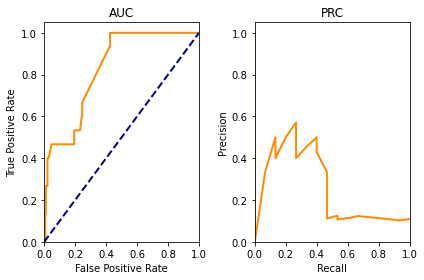

AUC: 82.99%, PRC: 25.06%


In [14]:
clf = MultinomialNB().fit(X_train_arr, y_train)
asset_prob = np.exp(clf.feature_log_prob_[0])
# clf.feature_log_prob_[0]
y_pred = (clf.predict_proba(X_test_arr))[:, 1]
evaluate_metrics(y_test, y_pred, show_plots = True)

### <font color=red>cross validation</font>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="500"/>

In [15]:
scores = cross_validate(clf, X_train_arr, y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores["test_score"].mean(), scores["test_score"].std()))

0.94 accuracy with a standard deviation of 0.01


### Assign Weight (kind of user preference)
- conditional prob

In [16]:
# log p(w|c=1) + log p(w|c=0)
import numpy as np
asset_prob = np.exp(clf.feature_log_prob_[0])

In [17]:
weights = pd.DataFrame([vectorizer.get_feature_names(), asset_prob.tolist()]).T
weights.columns = ["asset", "weight"]
weights.sort_values(by="weight", ascending=False).style

,asset,weight
6,/content/dam/rockwell-automation/sites/downloads/pdf/auto-sp010_-en-p.pdf,0.207878
9,/content/dam/rockwell-automation/sites/downloads/pdf/getting started in iab.pdf,0.162334
40,/content/rockwell-automation/www/na/us/en_us/company/news/case-studies/hirata-emulation-software.html,0.101968
42,/content/rockwell-automation/www/na/us/en_us/company/news/presentations/electric-vehicle-innovation-center.html,0.086293
5,/content/dam/rockwell-automation/sites/downloads/pdf/auto-ar001_-en-p.pdf,0.084872
41,/content/rockwell-automation/www/na/us/en_us/company/news/case-studies/maximum-transparency-across-all-levels-at-samsung-sdi-battery-sy.html,0.083936
10,/content/dam/rockwell-automation/sites/downloads/pdf/project design assistant.pdf,0.079534
7,/content/dam/rockwell-automation/sites/downloads/pdf/export a bom to proposalworks.pdf,0.032129
8,/content/dam/rockwell-automation/sites/downloads/pdf/generating a report.pdf,0.031670
11,/content/dam/rockwell-automation/sites/downloads/pdf/using the architecture view.pdf,0.031261


## Stage-2: Potential Lead - Sales people aspect
- with the label from sales people
    - type-1: interaction on Binge within lead status promote time range (30 days)
    - type-2: is existed qualified lead or not 
- conversion transition (which stage of conversion)
    - reading asset A has higher probably to become a existing lead compared with reading asset B
- assumption
    - <font color=red>only consider people already shows their interest in the funnel (only elq ID exist)</font>. So, this is kind of stage2 filter.
        - stage1 filter will consider anonomys visitors, and make them keep interest and leave information in elq first 
    - potential lead will have the similar interaction patterns as existing lead

### tables relationship
```SQL
FROM aem.RawTraffic AS binge 
    LEFT JOIN elo.Contact AS contact ON binge.EloquaContactId = contact.EloquaContactId
    LEFT JOIN crm.Lead AS lead ON lead.emailaddress1 = contact.EmailAddress
```
- relationship
    - elq is the bridge table 
        - elq ID : Email = <font color=red>N</font>:1 
        - overwrite
    - crm_lead
        - account id : Email = 1:N 
        - add new row
    - stage2_raw
        - session id : elq ID = 1:1
        - add new row
        - mvcid : elq ID = 1:N

In [18]:
crm_lead[["emailaddress1","createdon", "ra_leadstage", "ra_leadstagename", "statecode", "statecodename", "statuscode", "statuscodename"]].sort_values(by=['emailaddress1', 'createdon'])

,emailaddress1,createdon,ra_leadstage,ra_leadstagename,statecode,statecodename,statuscode,statuscodename
58319.0,01032409699@nate.com,2019-03-11 07:49:56,5.0,Awaiting Sales Qualification,2,Disqualified,953810014.0,Duplicate Lead
61532.0,012k.yamazaki@tam-tokyo.co.jp,2018-01-11 17:44:35,5.0,Awaiting Sales Qualification,2,Disqualified,4.0,Not buying or influence location
218822.0,012k.yamazaki@tam-tokyo.co.jp,2022-03-04 03:29:23,4.0,Awaiting Sales Acceptance,2,Disqualified,6.0,Not Decision Maker
107372.0,017089@cnkh.com,2020-04-29 19:37:00,5.0,Awaiting Sales Qualification,2,Disqualified,953810016.0,No buying intention
107374.0,017215@cnkh.com,2018-03-16 03:51:26,5.0,Awaiting Sales Qualification,2,Disqualified,4.0,Not buying or influence location
...,...,...,...,...,...,...,...,...
81138.0,zzq516@163.com,2017-09-21 06:00:00,5.0,Awaiting Sales Qualification,1,Qualified,3.0,Qualified
194288.0,zzq516@163.com,2018-01-08 04:18:52,5.0,Awaiting Sales Qualification,1,Qualified,3.0,Qualified
83729.0,zzq63@126.com,2016-12-24 06:00:00,5.0,Awaiting Sales Qualification,2,Disqualified,4.0,Not buying or influence location
253324.0,zzwj1009@163.com,2022-11-02 05:34:52,4.0,Awaiting Sales Acceptance,0,Open,1.0,New


### positive signal
1. method A: within a month & the statuscodename change from unQualified to Qualified
    1. ra_leadstage increase 1
2. <font color=red>method B: identify all the existing lead, find the visitor has the similar pattern on binge asset</font>

In [24]:
elq_bridge.groupby("EmailAddress").size().sort_values()

EmailAddress
!!edson.carlos!!@ensinger.co.uk          1
marina.schmidt@szmh-group.com            1
marina.schirmel@scherdel.de              1
marina.schiffer@scheidt-bachmann.com     1
marina.schetino@macrotec.ind.br          1
                                        ..
c_rudiyono@yahoo.com                    15
dixie_bvn@hotmail.com                   17
123@yahoo.com                           18
eric.dacer@ptcerna.com                  20
nancy.cordoba@elvatron.com              21
Length: 6257411, dtype: int64

In [28]:
stage2_raw

,SessionVisitorId,VisitStartDateTime,VisitPageNumber,VisitNumber,NewVisit,EventList,ExcludeHit,HitSource,DateTime_UTC,PageURL,...,PDFurl,PDFtitle,PDFpagecount,BingeId,BingeName,BingeCriticalScore,BingeCampaignId,BingeScoredAsset,BingeScoredAssetPath,BingeScoredAssetScore
0,7176155060582284921_8012265746597717484,2022-11-21 05:27:41,58,4,False,"215,216=70.00,10035,10036,10037,10038,10039,10...",0,1,2022-11-21 05:34:32+05:30,https://www.rockwellautomation.com/en-in/compa...,...,NaN,NaN,NaN,be1667335927367622,Digital Engineering and Design,2.0,CMP-05108-D0V3T8,What is New and Next at Rockwell Automation,/content/dam/rockwell-automation/videos/events...,1.0
1,5810965755297221743_6658970410020608210,2022-11-21 05:15:36,10,1,False,"215,216=10.00,217=2.00,10035,10036,10037,10038...",0,1,2022-11-21 05:16:06+00:00,https://www.rockwellautomation.com/en-us/indus...,...,/content/dam/rockwell-automation/sites/downloa...,Electric Vehicles And Smart Manufacturing - A ...,14.0,be1654108452838784,The Race to Electric Vehicle Production is Here,2.0,CMP-04453-F5G5H2,Electric Vehicles And Smart Manufacturing - A ...,/content/dam/rockwell-automation/sites/downloa...,2.0
2,5810965755297221743_6658970410020608210,2022-11-21 05:15:36,8,1,False,"215,216=9.00,10035,10036,10037,10038,10039,100...",0,1,2022-11-21 05:15:56+00:00,https://www.rockwellautomation.com/en-us/indus...,...,/content/dam/rockwell-automation/sites/downloa...,Electric Vehicles And Smart Manufacturing - A ...,14.0,be1654108452838784,The Race to Electric Vehicle Production is Here,2.0,CMP-04453-F5G5H2,Electric Vehicles And Smart Manufacturing - A ...,/content/dam/rockwell-automation/sites/downloa...,2.0
3,5796852693798854163_4240598388083859714,2022-11-21 04:37:41,85,52,False,"215,217=2.00,10035,10036,10037,10038,10039,113",0,1,2022-11-21 04:54:06+10:00,https://www.rockwellautomation.com/en-us/compa...,...,NaN,NaN,NaN,be1667920230989108,Expo On-Demand: Industry & Solutions Virtual T...,2.0,CMP-05108-D0V3T8,The Augmented Workforce,/content/dam/rockwell-automation/videos/capabi...,1.0
4,5796852693798854163_4240598388083859714,2022-11-21 04:37:41,77,52,False,"215,216=441.00,10035,10036,10037,10038,10039,5...",0,1,2022-11-21 04:49:46+10:00,https://www.rockwellautomation.com/en-us/compa...,...,NaN,NaN,NaN,be1667920230989108,Expo On-Demand Technology & Services Virtual T...,2.0,CMP-05108-D0V3T8,The Augmented Workforce,/content/dam/rockwell-automation/videos/capabi...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23817,6871057502780570223_6332759782801372912,2022-06-13 16:35:47,252,4,False,"215,217=2.00,10035,10036,10037,10038,10039,113",0,1,2022-06-13 17:29:04-04:00,https://locator.rockwellautomation.com/,...,/content/dam/rockwell-automation/sites/downloa...,Electric Vehicles And Smart Manufacturing - A ...,14.0,be1654108452838784,The Race to Electric Vehicle Production is Here,8.0,CMP-04453-F5G5H2,Electric Vehicles And Smart Manufacturing - A ...,/content/dam/rockwell-automation/sites/downloa...,2.0
23818,6871057502780570223_6332759782801372912,2022-06-13 16:35:47,160,4,False,"215,216=10.00,217=2.00,10035,10036,10037,10038...",0,1,2022-06-13 16:59:46-04:00,https://www.rockwellautomation.com/search/ra-e...,...,/content/dam/rockwell-automation/sites/downloa...,Electric Vehicles And Smart Manufacturing - A ...,14.0,be1654108452838784,The Race to Electric Vehicle Production is Here,8.0,CMP-04453-F5G5H2,Electric Vehicles And Smart Manufacturing - A ...,/content/dam/rockwell-automation/sites/downloa...,2.0
23819,6871057502780570223_6332759782801372912,2022-06-13 16:35:47,159,4,False,"215,216=9.00,10035,10036,10037,10038,10039,100...",0,1,2022-06-13 16:59:36-04:00,https://www.rockwellautomation.com/search/ra-e...,...,/content/dam/rockwell-automation/sites/downloa...,Electric Vehicles And Smart Manufacturing - A ...,14.0,be1654108452838784,The Race to Electric Vehicle Production is Here,8.0,CMP-04453-F5G5H2,Electric Vehicles And Smart Manufacturing - A 

In [19]:
def identify_pos(track, label_type = 2):
    if label_type == 1:
        pos_code_statuscode = [953810011.0, 3.0, 953810008.0]
        isPos = track["statuscode"].isin(pos_code_statuscode).any()
    elif label_type == 2:
        pos_code_ra_leadstage = [6.0, 7.0, 8.0]
        isPos = track["ra_leadstage"].isin(pos_code_ra_leadstage).any()
    return isPos

crm_qualify_label = crm_lead.groupby("emailaddress1").apply(lambda track: identify_pos(track, label_type = 2))
crm_qualify_label = crm_qualify_label.to_frame().reset_index()
crm_qualify_label.columns = ["emailaddress1", "label"]

In [20]:
track = crm_lead[crm_lead["emailaddress1"] == "jerry_li@lincolnelectric.com"]

In [ ]:
crm_qualify_label.label.value_counts()

In [ ]:
qualified_label = elq_bridge.merge(crm_qualify_label, left_on=["EmailAddress"], right_on=["emailaddress1"], how='inner')
qualified_label = qualified_label[["EloquaContactId","label", "EmailAddress", "emailaddress1"]]
print("keep rows:", qualified_label.shape)
qualified_label.info()
qualified_label["label"].value_counts()

In [42]:
stage2_raw["VisitStartDateTime"].min()

'2022-06-13 10:08:39'

In [ ]:
_data = stage2_raw.merge(qualified_label, on="EloquaContactId")
data = _data.groupby("SessionVisitorId").apply(lambda x: preprocessing_stage(x, stage=2))

#### to get mvsicd

In [33]:
elq_bridge

,EmailAddress,EloquaContactId
0,!!edson.carlos!!@ensinger.co.uk,CRACP000008935001
1,!burgerm@samcotech.com,CRACP000002957265
2,!burgerm@samcotech.com,CRACP000011807951
3,!pse-helpdesk@powersystem.org,CRACP000012845027
4,!rene.tassche@frieslandcampina.com,CRACP000012736983
...,...,...
7982365,zzzzxx1969@sina.com,CRACP000009711321
7982366,zzzzz830@hotmail.co.jp,CRACP000012653786
7982367,zzzzzacb@hanmail.net,CRACP000010761489
7982368,zzzzzz@gmail.com,CRACP000015406702


In [36]:
stage2_raw[["EloquaContactId", "mcvisid"]]

,EloquaContactId,mcvisid
0,NaN,62874529457173443381374915184087645012
1,NaN,56467893323718453580778155891064210215
2,NaN,56467893323718453580778155891064210215
3,CRACP000000122266,41473387534237163932216341118768730086
4,CRACP000000122266,41473387534237163932216341118768730086
...,...,...
23817,NaN,13084887784517264532774216958572431558
23818,NaN,13084887784517264532774216958572431558
23819,NaN,13084887784517264532774216958572431558
23820,CRACP000000774122,55445952645408503880733704262093500521


## 根据 mcvisid 获取对应的 email, EloquaContactId 都有 1 个 email 和 多个 mcvisid

1. email to label -> CRM.Lead
2. ??? 需要把 email append 到 RAW 上
2. mcvisid N: 1 email -> CRM.Lead
3. groupby email and aggregate assetpath

In [39]:
elq_bridge.merge(stage2_raw, left_on="EloquaContactId", right_on="EloquaContactId", how="left")

,EmailAddress,EloquaContactId,SessionVisitorId,VisitStartDateTime,VisitPageNumber,VisitNumber,NewVisit,EventList,ExcludeHit,HitSource,...,PDFurl,PDFtitle,PDFpagecount,BingeId,BingeName,BingeCriticalScore,BingeCampaignId,BingeScoredAsset,BingeScoredAssetPath,BingeScoredAssetScore
0,!!edson.carlos!!@ensinger.co.uk,CRACP000008935001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,!burgerm@samcotech.com,CRACP000002957265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,!burgerm@samcotech.com,CRACP000011807951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,!pse-helpdesk@powersystem.org,CRACP000012845027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,!rene.tassche@frieslandcampina.com,CRACP000012736983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7836863,zzzzxx1969@sina.com,CRACP000009711321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7836864,zzzzz830@hotmail.co.jp,CRACP000012653786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7836865,zzzzzacb@hanmail.net,CRACP000010761489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7836866,zzzzzz@gmail.com,CRACP000015406702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data split + TFIDF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data["features"], data["label"].values, test_size=TEST_SIZE, stratify=data["label"].values, random_state=SEED)

print("training sample label size:", Counter(y_train))
print("pos vs neg in training set:")
print(data["label"].value_counts())
print("testing sample label size:", Counter(y_test))

vectorizer = TfidfVectorizer(token_pattern=SEP_TOKEN_PATTERN)

X_train_arr = vectorizer.fit_transform(X_train)
X_test_arr = vectorizer.transform(X_test)

### Models

In [ ]:

clf = MultinomialNB().fit(X_train_arr, y_train)
asset_prob = np.exp(clf.feature_log_prob_[0])
clf.feature_log_prob_[0]

In [ ]:
weights = pd.DataFrame([vectorizer.get_feature_names(), asset_prob.tolist()]).T
weights.columns = ["asset", "weight"]
weights.sort_values(by="weight", ascending=False).style

In [ ]:
# weights["weight"]/weights["weight"].mean()

## Weight Rescaling
```python
default_critical_score = 1
if user click 0, 1, 2:
    then culmulative_score = 0.507937 + 0.349206 + 0.603175
        if culmulative_score > default_critical_score: 
            marked as potential qualify 
```

In [ ]:
a = weights.iloc[0:5,:]

In [ ]:
a["weight"]/a["weight"].sum() * 5

In [ ]:
a["weight"].mean()

In [ ]:
# elq_all_bridge-only.csv

In [ ]:
(a["weight"]/a["weight"].sum())

In [ ]:
a["weight"]

## Others 

### clustering based 
- how to estimated the probablity of some attributes
- how to assign weight based on this?

找到不同 status code 的数据分布是怎样的. 
- 确认方向之后, 对应的数据是否足够 是第一步. 
- 还是寻找数据

# Store model and prediction

# Post to AEM